In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import astropy as ap
import matplotlib.pyplot as plt
import scipy.stats
import astropy.time
import astropy.units as u
import astropy.constants as c

# style = "https://raw.githubusercontent.com/fedhere/DSPS/master/fbb.mplstyle"
# plt.style.use(style)

In [2]:
def mul_err(x, y, dx=0, dy=0):
    """
    Multiply two numbers with errors and propagate them.
    """
    z = x * y
    dz = np.abs(z) * np.sqrt((dx/x)**2 + (dy/y)**2)
    return z, dz


def div_err(x, y, dx=0, dy=0):
    """
    Divide two numbers with errors and propagate them.
    """
    z = x / y
    dz = np.abs(z) * np.sqrt((dx/x)**2 + (dy/y)**2)
    return z, dz

In [3]:
m31_csv = \
"https://raw.githubusercontent.com/fedhere/DSPS_FBianco/master/HW4/m31.csv"
mw_csv = \
"https://raw.githubusercontent.com/fedhere/DSPS_FBianco/master/HW4/mw.csv"

In [4]:
m31 = pd.read_csv(m31_csv, sep=",", skiprows=1)
mw = pd.read_csv(mw_csv, sep=",", skiprows=1)

In [5]:
new_colnames = ["r", "v", "dv", "err"]

m31_colnames = list(m31.columns)
m31_new_col_dict = {colname: new_colname for colname, new_colname 
                    in zip(m31_colnames, new_colnames)}

mw_colnames = list(mw.columns)
mw_new_col_dict = {colname: new_colname for colname, new_colname 
                   in zip(mw_colnames, new_colnames)}

In [6]:
m31 = m31.rename(m31_new_col_dict, axis=1)
mw = mw.rename(mw_new_col_dict, axis=1)

In [7]:
def physical_size(d, theta):
    """
    Return the physical size of an object from its angular size and distance.
    """
    L = 2 * d * np.tan(theta / 2)
    return L

In [8]:
m31_angular_size = (3.167 * u.deg).to(u.rad)
m31_distance = (2.54 * 10**6 * u.lyr).to(u.kpc)
m31_distance_err = (0.11 * 10**6 * u.lyr).to(u.kpc)
m31_physical_size = physical_size(m31_distance, m31_angular_size)

In [9]:
print(f"Angular size of luminous Andromeda: {m31_angular_size:.5f}")
print(f"Physical size of luminous Andromeda: {m31_physical_size:.1f}")

Angular size of luminous Andromeda: 0.05527 rad
Physical size of luminous Andromeda: 43.1 kpc


In [10]:
def velocity_at_nr(gal, gal_size, n):
    """
    Finds the last row in the data table where r <= gal_size * n.
    """
    data = m31[m31["r"] <= gal_size * n].iloc[-1]
    return data

In [11]:
velocity_at_nr(m31, m31_physical_size.value, 100)

r      1887.071
v       414.942
dv       69.579
err      27.931
Name: 54, dtype: float64

In [73]:
def plot_GRC(ax, gal, gal_size=None, n=None, c=None, label=None, text=False):
    
    if n is not None:
        data = velocity_at_nr(gal, gal_size, n)
    else:
        data = gal
        
    if c is None:
        c = "tab:blue"

    ax.errorbar(data["r"], data["v"],
                yerr=data["dv"], c=c,
                capsize=4, linewidth=2,
                alpha=0.5)

    ax.errorbar(data["r"], data["v"],
                yerr=data["err"], c=c,
                capsize=4, linewidth=2,
                label=label)
    
    if text:
        annotation = f"{data['v']:.1f}\n({data['dv']:.1f}, {data['err']:.1f})"
        ax.text(data["r"], data["v"] - data["dv"], annotation,
                ha="center", va="top")
        

def plotGal(gal, gal_size, xlim=(None, None)):
    fig, ax = plt.subplots(figsize=(12, 6))
    # ax.set_xscale("log")
    plot_GRC(ax, gal, label="GRC")

    plot_GRC(ax, gal,
             gal_size=gal_size, n=1,
             c="tab:orange", label="GRC at Gal Radius", text=True)
    plot_GRC(ax, gal,
             gal_size=gal_size, n=2,
             c="tab:green", label="GRC at 2x Gal Radius", text=True)
    plot_GRC(ax, gal,
             gal_size=gal_size, n=3,
             c="tab:red", label="GRC at 3x Gal Radius", text=True)

    plt.xlabel("Radius [kpc]")
    plt.ylabel("Velocity [km / s]")
    
    
    plt.xlim(xlim)
    plt.legend(fontsize=15)
    plt.show()

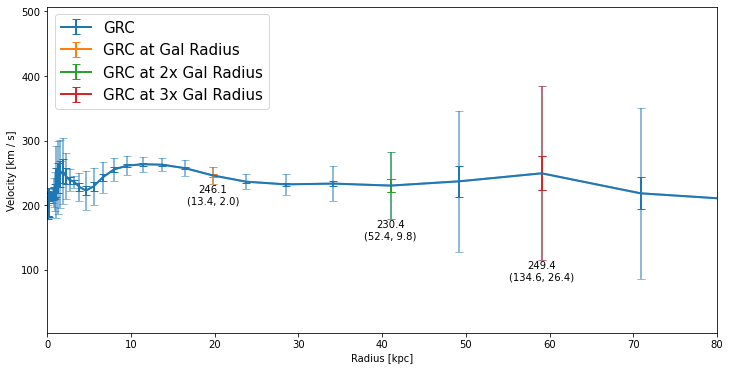

In [74]:
plotGal(m31, m31_physical_size.value / 2, xlim=(0, 80))

### Figure 1: The galactic rotation curve for M31 (Andromeda) is shown out to a radius of 80 kpc, just over three times the radius of the luminous mass in M31. Long and short error bars are displayed, representing modified standard deviations and modified errors. When all mass is included, we expect the velocity to decreas as 1/r, however this is not what is observed. This result is interpreted as the galaxy having more matter that is not luminous at large radii.

In [62]:
def GRC_summary(gal, gal_size, n, err="dv"):
    data0 = velocity_at_nr(gal, gal_size, 1)
    dataf = velocity_at_nr(gal, gal_size, n)
    
    ratio, stderr = div_err(dataf["v"], data0["v"],
                            dx=dataf[err], dy=data0[err])

    print(f"At N = {n:.2f} radii from the galactic center:")
    print(f"The expected drop in rotational velocity is {n:.2f}.")
    print(f"The measured drop in rotational velocity is {ratio:.3f} ± {stderr:.3f}")
    print(f"The 2-sigma upper and lower limits for the rotational velocity are {ratio - 2 * stderr:.3f} to {ratio + 2 * stderr:.3f}.")
    
    agreement = (n > ratio - 2*stderr) & (n < ratio + 2*stderr)
    if agreement:
        print("The measured drop in rotational velocity AGREE with Newton's laws.")
    else:
        print("The measured drop in rotational velocity DO NOT AGREE with Newton's laws.")

In [64]:
for n in np.linspace(1, 5, num=9):
    GRC_summary(m31, m31_physical_size.value, n, err="dv")
    print()

At N = 1.00 radii from the galactic center:
The expected drop in rotational velocity is 1.00.
The measured drop in rotational velocity is 1.000 ± 0.322
The 2-sigma upper and lower limits for the rotational velocity are 0.356 to 1.644.
The measured drop in rotational velocity AGREE with Newton's laws.

At N = 1.50 radii from the galactic center:
The expected drop in rotational velocity is 1.50.
The measured drop in rotational velocity is 1.082 ± 0.634
The 2-sigma upper and lower limits for the rotational velocity are -0.185 to 2.350.
The measured drop in rotational velocity AGREE with Newton's laws.

At N = 2.00 radii from the galactic center:
The expected drop in rotational velocity is 2.00.
The measured drop in rotational velocity is 0.897 ± 0.620
The 2-sigma upper and lower limits for the rotational velocity are -0.344 to 2.137.
The measured drop in rotational velocity AGREE with Newton's laws.

At N = 2.50 radii from the galactic center:
The expected drop in rotational velocity is 2

### At 2.5 galactic radii away, the expected ratio is no longer within 2 sigma of the measured ratio. This indicates that the data is not consistent with Newton's laws beyond 2.5 galactic radii.

In [67]:
mw_physical_size = (185 * u.klyr).to(u.kpc)

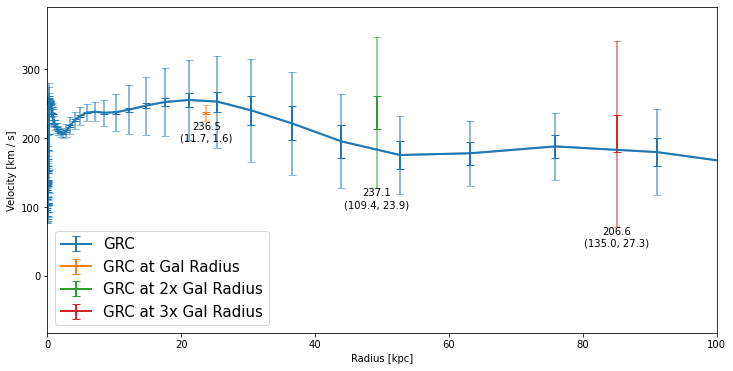

In [77]:
plotGal(mw, mw_physical_size.value / 2, xlim=(0, 100))

### Figure 2: The galactic rotation curve for the Via Lacta (Milky Way) is shown out to a radius of 100 kpc, just over three times the radius of the luminous mass in the Milky Way. Long and short error bars are displayed, representing modified standard deviations and modified errors. When all mass is included, we expect the velocity to decreas as 1/r, however this is not what is observed. This result is interpreted as the galaxy having more matter that is not luminous at large radii.

In [68]:
for n in np.linspace(1, 5, num=9):
    GRC_summary(mw, mw_physical_size.value, n, err="dv")
    print()

At N = 1.00 radii from the galactic center:
The expected drop in rotational velocity is 1.00.
The measured drop in rotational velocity is 1.000 ± 0.653
The 2-sigma upper and lower limits for the rotational velocity are -0.305 to 2.305.
The measured drop in rotational velocity AGREE with Newton's laws.

At N = 1.50 radii from the galactic center:
The expected drop in rotational velocity is 1.50.
The measured drop in rotational velocity is 0.871 ± 0.697
The 2-sigma upper and lower limits for the rotational velocity are -0.523 to 2.266.
The measured drop in rotational velocity AGREE with Newton's laws.

At N = 2.00 radii from the galactic center:
The expected drop in rotational velocity is 2.00.
The measured drop in rotational velocity is 0.898 ± 0.696
The 2-sigma upper and lower limits for the rotational velocity are -0.493 to 2.290.
The measured drop in rotational velocity AGREE with Newton's laws.

At N = 2.50 radii from the galactic center:
The expected drop in rotational velocity is 

### Again we find that the expected value from Newton's laws and the measured values do not agree after a radius of 2.5 galactic radii.

# PHYS 661